In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Phishing-Project/data/texts/phishing_email_cleaned.csv')

In [ ]:
!pip uninstall -y fsspec
!pip install -U fsspec sentence-transformers --no-cache-dir

Found existing installation: fsspec 2025.5.1
Uninstalling fsspec-2025.5.1:
  Successfully uninstalled fsspec-2025.5.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 7.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.5.1 which is incompatible.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack, csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
texts = df['Email Text'].fillna("")
labels = df['Email Type']

TF-IDF (word+char)

In [ ]:
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_features=3000, stop_words='english', min_df=2, max_df=0.95)
char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3,5), max_features=2000)
X_word = word_vectorizer.fit_transform(texts)
X_char = char_vectorizer.fit_transform(texts)
X_tfidf = hstack([X_word, X_char])

BERT Embeddings (MiniLM)

In [ ]:
import numpy as np

# to load bert
import os
bert_path = '/content/drive/MyDrive/Phishing-Project/X_bert.npy'
if os.path.exists(bert_path):
    print("Loading saved BERT embeddings from file...")
    X_bert = np.load(bert_path)
else:
    print("Encoding BERT embeddings ...")
    bert_model = SentenceTransformer('all-MiniLM-L6-v2')
    X_bert = bert_model.encode(texts.tolist(), show_progress_bar=True)
    np.save(bert_path, X_bert)

scaler = StandardScaler()
X_bert_scaled = scaler.fit_transform(X_bert)
X_bert_sparse = csr_matrix(X_bert_scaled)

# Combine with TF-IDF
X_combined = hstack([X_tfidf, X_bert_sparse])
y = labels

Encoding BERT embeddings ...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/566 [00:00<?, ?it/s]

Reload when needed

In [ ]:
import joblib
import numpy as np

# Load vectorizers
word_vectorizer = joblib.load('/content/drive/MyDrive/Phishing-Project/Models to Load/word_vectorizer.pkl')
char_vectorizer = joblib.load('/content/drive/MyDrive/Phishing-Project/Models to Load/char_vectorizer.pkl')

# Transform the text
X_word = word_vectorizer.transform(texts)
X_char = char_vectorizer.transform(texts)
X_tfidf = hstack([X_word, X_char])

# load scaler and BERT embeddings
scaler = joblib.load('/content/drive/MyDrive/Phishing-Project/Models to Load/scaler.pkl')
X_bert = np.load('/content/drive/MyDrive/Phishing-Project/Models to Load/X_bert.npy')
X_bert_scaled = scaler.transform(X_bert)
X_bert_sparse = csr_matrix(X_bert_scaled)

X_combined = hstack([X_tfidf, X_bert_sparse])

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

In [ ]:
print("Label classes:", list(le.classes_))
print("Encoded labels (first 10):", y_encoded[:10])

Label classes: ['Phishing Email', 'Safe Email']
Encoded labels (first 10): [1 1 1 0 0 1 1 0 0 1]


In [ ]:
import joblib
joblib.dump(le, "label_encoder.pkl")  # to Save

['label_encoder.pkl']

In [ ]:
# to load
le = joblib.load("label_encoder.pkl")
y_encoded = le.transform(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [ ]:
import joblib

joblib.dump(word_vectorizer, '/content/drive/MyDrive/Phishing-Project/word_vectorizer.pkl')
joblib.dump(char_vectorizer, '/content/drive/MyDrive/Phishing-Project/char_vectorizer.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/Phishing-Project/scaler.pkl')

['/content/drive/MyDrive/Phishing-Project/scaler.pkl']

Model Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), {'C': [0.1, 1, 5], 'solver': ['liblinear']}, cv=5, n_jobs=-1).fit(X_train_bal, y_train_bal)
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}, cv=5, n_jobs=-1).fit(X_train_bal, y_train_bal)
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.1, 0.3]}, cv=5, n_jobs=-1).fit(X_train_bal, y_train_bal)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:11:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import joblib

# Save the tuned base models
joblib.dump(lr_grid.best_estimator_, '/content/drive/MyDrive/Phishing-Project/lr_model.pkl')
joblib.dump(rf_grid.best_estimator_, '/content/drive/MyDrive/Phishing-Project/rf_model.pkl')
joblib.dump(xgb_grid.best_estimator_, '/content/drive/MyDrive/Phishing-Project/xgb_model.pkl')

['/content/drive/MyDrive/Phishing-Project/xgb_model.pkl']

In [ ]:
import joblib

lr_model= joblib.load('/content/drive/MyDrive/Phishing-Project/Models to Load/lr_model.pkl')
rf_model= joblib.load('/content/drive/MyDrive/Phishing-Project/Models to Load/rf_model.pkl')
xgb_model= joblib.load('/content/drive/MyDrive/Phishing-Project/Models to Load/xgb_model.pkl')

In [ ]:
base_models = [
    ('rf', rf_model),
    ('svm', LinearSVC(random_state=42, max_iter=10000)),
    ('xgb', xgb_model)
]
meta_model = lr_model
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

In [ ]:
stacked_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(n_estimators=200,
                                                       random_state=42)),
                               ('svm',
                                LinearSVC(max_iter=10000, random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval...
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression(C=5, max_iter=1000,
                                                      solver='liblinear'),
                   n_jobs=-1)

In [ ]:
# to save stacked model
joblib.dump(stacked_model, '/content/drive/MyDrive/Phishing-Project/stacked_model.pkl')

['/content/drive/MyDrive/Phishing-Project/stacked_model.pkl']

Accuracy: 0.989217583632845
ROC AUC: 0.9882814315668786
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1393
           1       0.99      0.99      0.99      2224

    accuracy                           0.99      3617
   macro avg       0.99      0.99      0.99      3617
weighted avg       0.99      0.99      0.99      3617

Confusion Matrix:
 [[1371   22]
 [  17 2207]]


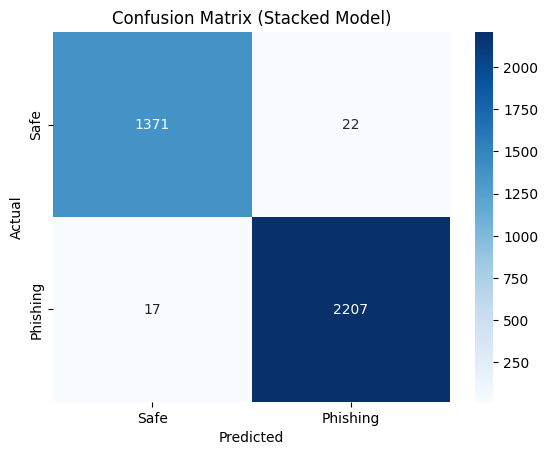

In [ ]:
y_pred = stacked_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'Phishing'], yticklabels=['Safe', 'Phishing'])
plt.title("Confusion Matrix (Stacked Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Custom Test

In [ ]:
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [25]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Calculate optimal F1 threshold from validation data
precision, recall, thresholds = precision_recall_curve(y_test, stacked_model.predict_proba(X_test)[:, 1])
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# override threshold for aggressive phishing detection
threshold = 0.3  # set to optimal_threshold to use the best F1
print(f"Using Threshold: {threshold:.2f} (Optimal from F1 was {optimal_threshold:.2f})")

# Reuse custom test emails
sample_emails = [
    "⚠️ We noticed unusual login activity. Please verify your identity immediately.",
    "Your Netflix account will be suspended unless you update your payment method.",
    "Congratulations! You've won a free iPhone. Click here to claim now.",
    "Reminder: Your order #98423 has shipped. Track here.",
    "Meeting rescheduled to 3 PM. Please check your calendar.",
    "Update: New privacy policy effective from next week. No action needed."
]

# Vectorize
X_test_word = word_vectorizer.transform(sample_emails)
X_test_char = char_vectorizer.transform(sample_emails)
X_test_tfidf = hstack([X_test_word, X_test_char])
X_test_bert = bert_model.encode(sample_emails)
X_test_bert_scaled = scaler.transform(X_test_bert)
X_test_bert_sparse = csr_matrix(X_test_bert_scaled)
X_test_all = hstack([X_test_tfidf, X_test_bert_sparse])

# Predict probability and classify
probas = stacked_model.predict_proba(X_test_all)[:, 1]
custom_preds = (probas > threshold).astype(int)

# Result analysis
print("\n Final Predictions with Smart Threshold:")
for text, prob, pred in zip(sample_emails, probas, custom_preds):
    label = 'Phishing' if pred == 0 else 'Safe'
    comment = ""
    if label == "Phishing" and prob > 0.2:
        comment = "⚠️ borderline case, review manually"
    elif label == "Safe" and prob < 0.7:
        comment = "⚠️ potentially suspicious, consider raising threshold"

    print(f" {text}\n→ {label} (Confidence: {prob:.2f} {comment})\n")


Using Threshold: 0.30 (Optimal from F1 was 0.46)

 Final Predictions with Smart Threshold:
 ⚠️ We noticed unusual login activity. Please verify your identity immediately.
→ Phishing (Confidence: 0.01 )

 Your Netflix account will be suspended unless you update your payment method.
→ Phishing (Confidence: 0.21 ⚠️ borderline case, review manually)

 Congratulations! You've won a free iPhone. Click here to claim now.
→ Phishing (Confidence: 0.00 )

 Reminder: Your order #98423 has shipped. Track here.
→ Phishing (Confidence: 0.25 ⚠️ borderline case, review manually)

 Meeting rescheduled to 3 PM. Please check your calendar.
→ Safe (Confidence: 0.99 )

 Update: New privacy policy effective from next week. No action needed.
→ Safe (Confidence: 0.97 )

